In [1]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean

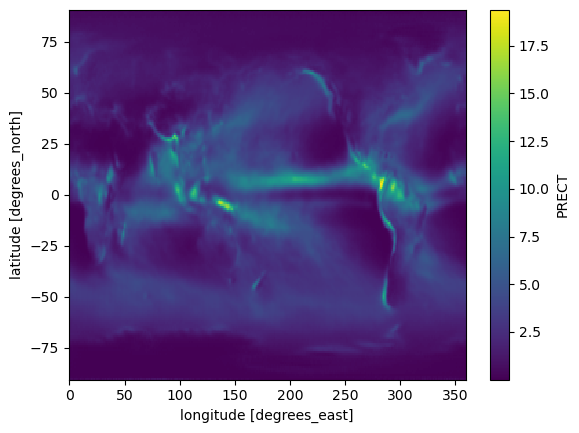

In [37]:
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/1D/*.nc'))
DS = xr.open_mfdataset(FNS[:48])
(DS['PRECT'].mean(['time'])*4000).plot()

starting


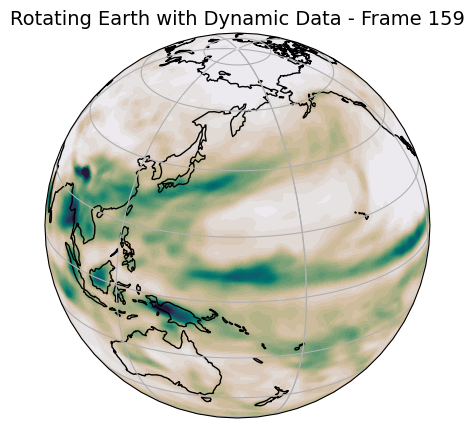

In [55]:
print('starting')
# Create the figure and axis
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=23.5))  # Earth's axial tilt ~23.5°
ax.set_global()
ax.coastlines()

# Dummy data grid (static longitude and latitude)
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Initial data
data_np = DS['PRECT'].values*4000

# Initial plot with the colorbar
img = ax.contourf(
    lon_grid, lat_grid, data_np[0,:,:], 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, vmin=0,vmax=30
)
# cbar = plt.colorbar(img, ax=ax, orientation="horizontal", pad=0.05, aspect=50)
# cbar.set_label("Dynamic Data")

# Update function for animation
def update(frame):
    ax.clear()  # Clear the axis
    ax.set_global()
    ax.coastlines()
    ax.gridlines()
    # Update projection for rotation
    normalized_frame = frame % 360
    ax.projection = ccrs.Orthographic(central_longitude=normalized_frame, central_latitude=23.5)

    # Generate new dynamic data
    if frame > 100:
        data = np.mean(data_np[100:frame,:,:],axis=0)
        vma = 30 - (frame - 100)
    else: 
        data = data_np[frame,:,:]
        vma = 29
        
    if vma < 20:
        vma = 20

    # Plot updated data
    img = ax.contourf(
        lon_grid, lat_grid, data, 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, vmin=0, vmax=vma
    )


    # Add a title
    ax.set_title(f"Rotating Earth with Dynamic Data - Frame {frame}", fontsize=14)

# Create the animation
anim = FuncAnimation(fig, update, frames=np.arange(100, 160, 1), interval=50)

# Save the animation (optional)
anim.save("rotating_tilted_dynamic_earth.mp4", writer="ffmpeg", fps=12)

plt.show()


starting


Rendering animation: 61it [04:03,  3.99s/it]                        


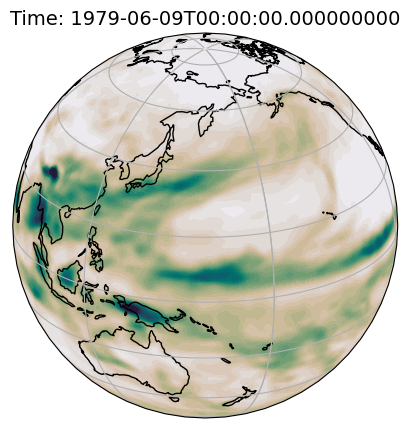

In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from tqdm import tqdm

# Parameters for customization
central_latitude = 23.5  # Earth's axial tilt ~23.5°
fps = 12
output_file = "rotating_tilted_dynamic_earth.mp4"

# Assuming `DS` is a dataset object with variables 'longitude', 'latitude', 'PRECT', and 'time'
print('starting')

# Create the figure and axis
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0, central_latitude=central_latitude))
ax.set_global()
ax.coastlines()

# Data grid
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Initial data
data_np = DS['PRECT'].values * 4000

# Initial plot with the colorbar
img = ax.contourf(
    lon_grid, lat_grid, data_np[0, :, :], 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, vmin=0, vmax=30
)

# Helper function to reset the axis
def reset_axis(ax, central_longitude):
    ax.clear()
    ax.set_global()
    ax.coastlines()
    ax.gridlines()
    ax.projection = ccrs.Orthographic(central_longitude=central_longitude, central_latitude=central_latitude)

# Update function for animation
def update(frame):
    reset_axis(ax, frame % 360)

    # Generate new dynamic data
    if frame > 100:
        data = np.mean(data_np[100:frame, :, :], axis=0)
        vma = 30 - (frame - 100)
    else:
        data = data_np[frame, :, :]
        vma = 29

    if vma < 20:
        vma = 20

    # Update the contour plot
    img = ax.contourf(
        lon_grid, lat_grid, data, 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, vmin=0, vmax=vma
    )

    # Add a title based on time
    current_time = DS['time'].values[frame]
    ax.set_title(f"Time: {current_time}", fontsize=14)

# Create the animation with tqdm progress bar
frames = np.arange(100, 160, 1)
with tqdm(total=len(frames), desc="Rendering animation") as pbar:

    def update_with_progress(frame):
        update(frame)
        pbar.update(1)

    anim = FuncAnimation(fig, update_with_progress, frames=frames, interval=1000 / fps, blit=False)

    # Save the animation
    anim.save(output_file, writer="ffmpeg", fps=fps)

plt.show()


In [57]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from tqdm import tqdm
import multiprocessing as mp
import os

# Parameters for customization
central_latitude = 23.5  # Earth's axial tilt ~23.5°
fps = 15
output_file = "rotating_tilted_dynamic_earth.mp4"

# Assuming `DS` is a dataset object with variables 'longitude', 'latitude', 'PRECT', and 'time'
print('starting')

# Data grid
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Wrap longitude grid for smooth transitions
lon_grid_wrapped = np.concatenate((lon_grid, lon_grid[:, :1] + 360), axis=1)
lat_grid_wrapped = np.concatenate((lat_grid, lat_grid[:, :1]), axis=1)  # Adjust lat_grid for consistency
data_np = DS['PRECT'].values * 4000

# Wrap data for smooth transitions
data_wrapped = np.concatenate((data_np, data_np[:, :, :1]), axis=2)

# Function to generate a single frame
def generate_frame(frame):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=frame % 360, central_latitude=central_latitude))
    ax.set_global()
    ax.coastlines()

    # Generate new dynamic data
    if frame > 100:
        data = np.mean(data_wrapped[100:frame, :, :], axis=0)
        vma = 30 - (frame - 100)
    else:
        data = data_wrapped[frame, :, :]
        vma = 29

    if vma < 20:
        vma = 20

    # Plot the data
    img = ax.contourf(
        lon_grid_wrapped, lat_grid_wrapped, data, 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, vmin=0, vmax=vma
    )

    # Add a title based on time
    current_time = str(DS['time'].values[frame])[:10]  # Truncate to the day
    ax.set_title(f"Time: {current_time}", fontsize=14)

    # Save the frame
    frame_file = f"frame_{frame:06d}.png"
    plt.savefig(frame_file, dpi=100, bbox_inches='tight')
    plt.close(fig)
    return frame_file

# Parallel frame generation in batches
frames = np.arange(100, 420, 1)
batch_size = 60
frame_files = []

for batch_start in range(0, len(frames), batch_size):
    batch_frames = frames[batch_start:batch_start + batch_size]
    with tqdm(total=len(batch_frames), desc=f"Rendering batch {batch_start // batch_size + 1}") as pbar:
        with mp.Pool(processes=32) as pool:
            for frame_file in pool.imap_unordered(generate_frame, batch_frames):
                frame_files.append(frame_file)
                pbar.update(1)

# Debugging: Check if all frames are generated
for frame_file in frame_files:
    if not os.path.exists(frame_file):
        print(f"Warning: Frame file {frame_file} does not exist.")

# Combine frames into video using ffmpeg
print("Combining frames into video...")
if frame_files:
    # os.system("ls frame_*.png")  # List generated files for debugging
    os.system(f"ffmpeg -r {fps} -pattern_type glob -i 'frame_*.png' -vf 'scale=trunc(iw/2)*2:trunc(ih/2)*2' -vcodec libx264 -pix_fmt yuv420p -y {output_file}")
else:
    print("No frames found to combine.")




starting


Rendering batch 6: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]
ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-11)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-l

Combining frames into video...


[out#0/mp4 @ 0x557b4539dc80] video:1166KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.396454%
frame=  320 fps=0.0 q=-1.0 Lsize=    1170KiB time=00:00:21.20 bitrate= 452.2kbits/s speed=50.5x    
[libx264 @ 0x557b453a2ac0] frame I:2     Avg QP:19.07  size: 23508
[libx264 @ 0x557b453a2ac0] frame P:81    Avg QP:22.90  size:  8785
[libx264 @ 0x557b453a2ac0] frame B:237   Avg QP:29.15  size:  1833
[libx264 @ 0x557b453a2ac0] consecutive B-frames:  1.2%  0.0%  0.0% 98.8%
[libx264 @ 0x557b453a2ac0] mb I  I16..4: 12.1% 38.7% 49.2%
[libx264 @ 0x557b453a2ac0] mb P  I16..4:  0.6%  1.5%  1.6%  P16..4: 20.9% 23.6% 19.8%  0.0%  0.0%    skip:32.1%
[libx264 @ 0x557b453a2ac0] mb B  I16..4:  0.1%  0.4%  0.1%  B16..8: 32.8%  8.0%  2.6%  direct: 3.7%  skip:52.3%  L0:33.7% L1:38.5% BI:27.8%
[libx264 @ 0x557b453a2ac0] 8x8 transform intra:46.4% inter:39.1%
[libx264 @ 0x557b453a2ac0] coded y,uvDC,uvAC intra: 47.0% 50.3% 38.5% inter: 14.4% 8.2% 1.7%
[libx264 @ 0x557b453a2a

# Remove the Files 

In [58]:
# Clean up temporary frame files
for frame_file in frame_files:
    if os.path.exists(frame_file):
        os.remove(frame_file)

print("Animation saved as", output_file)

Animation saved as rotating_tilted_dynamic_earth.mp4


## Different Map Projection! 

In [4]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from dask.distributed import Client, get_client
import time
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(3)

# Glob the NetCDF files
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/pred*.nc'))[:7300]

# Prepare lists to store data and times
prect_list = []
time_list = []

# Define batch size
batch_size = 500  # Number of files to open at once

# Process files in batches
for i in range(0, len(FNS), batch_size):
    batch_files = FNS[i:i + batch_size]
    print(f"Processing batch {i // batch_size + 1} with {len(batch_files)} files...")

    # Open the batch of files lazily
    DS = xr.open_mfdataset(batch_files, combine='by_coords', data_vars=['PRECT'])

    # Access 'PRECT' variable and load into memory
    prect_batch = DS['PRECT'].values
    prect_list.append(prect_batch)

    # Access 'time' variable and load into memory
    time_batch = DS['time'].values
    time_list.append(time_batch)

    # Close the dataset to free memory
    DS.close()

# Concatenate all batches into a single NumPy array
prect_np = np.concatenate(prect_list, axis=0)
time_np = np.concatenate(time_list, axis=0)

# Close the Dask client
client.close()

print(f"PRECT data shape: {prect_np.shape}")
print(f"Time data shape: {time_np.shape}")

No active client found.


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39737 instead
  warnings.warn(


Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/39737/status
Processing batch 1 with 500 files...
Processing batch 2 with 500 files...
Processing batch 3 with 500 files...
Processing batch 4 with 500 files...
Processing batch 5 with 500 files...
Processing batch 6 with 500 files...
Processing batch 7 with 500 files...
Processing batch 8 with 500 files...
Processing batch 9 with 500 files...
Processing batch 10 with 500 files...
Processing batch 11 with 500 files...
Processing batch 12 with 500 files...
Processing batch 13 with 500 files...
Processing batch 14 with 500 files...
Processing batch 15 with 300 files...
PRECT data shape: (7300, 192, 288)
Time data shape: (7300,)


## Gen Images and Video

In [22]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from tqdm import tqdm
import multiprocessing as mp
import os

# Parameters for customization
central_latitude = 23.5  # Earth's axial tilt ~23.5°
fps = 20
output_file = "Robinson_dynamic_earth.mp4"

# Assuming `DS` is a dataset object with variables 'longitude', 'latitude', 'PRECT', and 'time'
print('starting')

# Data grid
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Wrap longitude grid for smooth transitions
lon_grid_wrapped = np.concatenate((lon_grid, lon_grid[:, :1] + 360), axis=1)
lat_grid_wrapped = np.concatenate((lat_grid, lat_grid[:, :1]), axis=1)  # Adjust lat_grid for consistency
data_np = prect_np * 4000

# Wrap data for smooth transitions
data_wrapped = np.concatenate((data_np, data_np[:, :, :1]), axis=2)

# Function to generate a single frame
def generate_frame(frame):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    ax.set_global()
    ax.coastlines()

    # Generate new dynamic data
    if frame > 1:
        data = np.mean(data_wrapped[1:frame, :, :], axis=0)
        vma = 30 - (frame - 1)
    else:
        data = data_wrapped[frame, :, :]
        vma = 29

    if vma < 20:
        vma = 20

    # Plot the data
    img = ax.contourf(
        lon_grid_wrapped, lat_grid_wrapped, data, 65, transform=ccrs.PlateCarree(), cmap=cmocean.cm.rain, vmin=0, vmax=vma
    )

    # Add a title based on time
    current_time = str(time_np[frame])[:10]  # Truncate to the day
    ax.set_title(f"Time: {current_time}", fontsize=14)

    # Save the frame
    frame_file = f"./Frames/frame_{frame:06d}.png"
    plt.savefig(frame_file, dpi=100, bbox_inches='tight')
    plt.close(fig)
    return frame_file

# Parallel frame generation in batches
frames = np.arange(1, 7299, 1)
batch_size = 100
frame_files = []

for batch_start in range(0, len(frames), batch_size):
    batch_frames = frames[batch_start:batch_start + batch_size]
    with tqdm(total=len(batch_frames), desc=f"Rendering batch {batch_start // batch_size + 1}") as pbar:
        with mp.Pool(processes=32) as pool:
            for frame_file in pool.imap_unordered(generate_frame, batch_frames):
                frame_files.append(frame_file)
                pbar.update(1)

# Debugging: Check if all frames are generated
for frame_file in frame_files:
    if not os.path.exists(frame_file):
        print(f"Warning: Frame file {frame_file} does not exist.")

# Combine frames into video using ffmpeg
print("Combining frames into video...")
if frame_files:
    # os.system("ls frame_*.png")  # List generated files for debugging
    os.system(f'ffmpeg -pattern_type glob -i "./Frames/frame_*.png" -filter:v "setpts=if(lt(N\\,100),N/10,if(lt(N\\,500),N/40,N/60))*PTS" -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -pix_fmt yuv420p -y {output_file}')
else:
    print("No frames found to combine.")




starting


Rendering batch 73: 100%|██████████| 98/98 [00:39<00:00,  2.48it/s]


Combining frames into video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-11)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-lib

## Remove the Files

In [26]:
# Clean up temporary frame files
for frame_file in frame_files:
    if os.path.exists(frame_file):
        os.remove(frame_file)

print("Animation saved as", output_file)

Animation saved as Robinson_dynamic_earth.mp4


In [2]:
# Glob the NetCDF files
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/pred*.nc'))[:1470]
DS = xr.open_dataset(FNS[0])

## TAUX 

In [1]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from dask.distributed import Client, get_client
import time
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(3)

# Glob the NetCDF files
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/pred*.nc'))[:1470]

# Prepare lists to store data and times
prect_list = []
time_list = []

# Define batch size
batch_size = 500  # Number of files to open at once

# Process files in batches
for i in range(0, len(FNS), batch_size):
    batch_files = FNS[i:i + batch_size]
    print(f"Processing batch {i // batch_size + 1} with {len(batch_files)} files...")

    # Open the batch of files lazily
    DS = xr.open_mfdataset(batch_files, combine='by_coords', data_vars=['Qtot'])

    # Access 'PRECT' variable and load into memory
    prect_batch = DS['Qtot'].isel(level=31).values
    prect_list.append(prect_batch)

    # Access 'time' variable and load into memory
    time_batch = DS['time'].values
    time_list.append(time_batch)

    # Close the dataset to free memory
    DS.close()

# Concatenate all batches into a single NumPy array
prect_np = np.concatenate(prect_list, axis=0)
time_np = np.concatenate(time_list, axis=0)

# Close the Dask client
client.close()

print(f"PRECT data shape: {prect_np.shape}")
print(f"Time data shape: {time_np.shape}")

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status
Processing batch 1 with 500 files...
Processing batch 2 with 500 files...
Processing batch 3 with 470 files...
PRECT data shape: (1470, 192, 288)
Time data shape: (1470,)


In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from tqdm import tqdm
import multiprocessing as mp
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Parameters for customization
central_latitude = 23.5  # Earth's axial tilt ~23.5°
fps = 13
output_file = "Robinson_Qtot_dynamic_earth.mp4"

# Assuming `DS` is a dataset object with variables 'longitude', 'latitude', 'PRECT', and 'time'
print('starting')

# Data grid
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Wrap longitude grid for smooth transitions
lon_grid_wrapped = np.concatenate((lon_grid, lon_grid[:, :1] + 360), axis=1)
lat_grid_wrapped = np.concatenate((lat_grid, lat_grid[:, :1]), axis=1)  # Adjust lat_grid for consistency
data_np = prect_np*1000
# Wrap data for smooth transitions
data_wrapped = np.concatenate((data_np, data_np[:, :, :1]), axis=2)


# Parameters
time_steps_per_day = 4  # 6-hourly data
rolling_window = 30 * time_steps_per_day  # 30-day window (120 steps)
half_window = rolling_window // 2  # Half-window size (60 steps)

# Placeholder for the rolling mean data
rolling_mean_data = np.empty_like(data_wrapped)

# Perform the rolling mean calculation
for t in range(len(data_wrapped)):
    start = max(0, t - half_window)  # Ensure we don't go below index 0
    end = min(len(data_wrapped), t + half_window + 1)  # Ensure we don't exceed the array length
    rolling_mean_data[t] = np.mean(data_wrapped[start:end], axis=0)

# Print shapes to confirm
print(f"Original data shape: {data_wrapped.shape}")
print(f"Rolling mean data shape: {rolling_mean_data.shape}")

# Create a modified colormap with white in the middle
cmap = cmocean.cm.curl  # Choose a base colormap
colors = cmap(np.linspace(0, 1, 256))
midpoint = 64  # Midpoint for white
# colors[midpoint] = [1, 1, 1, 1]  # Set middle color to white
new_cmap = mcolors.ListedColormap(colors)

# Function to generate a single frame
def generate_frame(frame):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    ax.set_global()
    ax.coastlines()

    data = data_wrapped[frame, :, :]
    vma = 18
    vmi =0 

    # Plot the data
    img = ax.contourf(
        lon_grid_wrapped, lat_grid_wrapped, data, 128, transform=ccrs.PlateCarree(), cmap=new_cmap, vmin=vmi, vmax=vma
    )
    img = ax.contour(lon_grid_wrapped, lat_grid_wrapped, rolling_mean_data[frame,:,:], levels=[2,4,6,8,10,12,15], transform=ccrs.PlateCarree(), colors='k', alpha=0.2)

    # Add a title based on time
    current_time = str(time_np[frame])[:10]  # Truncate to the day
    ax.set_title(f"Time: {current_time}", fontsize=14)

    # Save the frame
    frame_file = f"./Frames/frame_{frame:06d}.png"
    plt.savefig(frame_file, dpi=200, bbox_inches='tight')
    plt.close(fig)
    return frame_file

# Parallel frame generation in batches
frames = np.arange(1, 1460, 1)
batch_size = 100
frame_files = []

for batch_start in range(0, len(frames), batch_size):
    batch_frames = frames[batch_start:batch_start + batch_size]
    with tqdm(total=len(batch_frames), desc=f"Rendering batch {batch_start // batch_size + 1}") as pbar:
        with mp.Pool(processes=32) as pool:
            for frame_file in pool.imap_unordered(generate_frame, batch_frames):
                frame_files.append(frame_file)
                pbar.update(1)

# Debugging: Check if all frames are generated
for frame_file in frame_files:
    if not os.path.exists(frame_file):
        print(f"Warning: Frame file {frame_file} does not exist.")

# Combine frames into video using ffmpeg
print("Combining frames into video...")
if frame_files:
    # os.system("ls frame_*.png")  # List generated files for debugging
    os.system(f'ffmpeg -pattern_type glob -i "./Frames/frame_*.png" -filter:v "setpts=if(lt(N\\,100),N/10,if(lt(N\\,500),N/40,N/60))*PTS" -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -pix_fmt yuv420p -y {output_file}')
else:
    print("No frames found to combine.")


starting
Original data shape: (1470, 192, 289)
Rolling mean data shape: (1470, 192, 289)


Rendering batch 15: 100%|██████████| 59/59 [00:32<00:00,  1.82it/s]
ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-11)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-

Combining frames into video...


[out#0/mp4 @ 0x55cddea36680] video:34677KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.052947%
frame= 1459 fps=222 q=-1.0 Lsize=   34695KiB time=00:00:58.28 bitrate=4876.9kbits/s speed=8.86x    
[libx264 @ 0x55cddea37400] frame I:6     Avg QP:21.71  size:113282
[libx264 @ 0x55cddea37400] frame P:367   Avg QP:25.71  size: 44630
[libx264 @ 0x55cddea37400] frame B:1086  Avg QP:26.84  size: 16989
[libx264 @ 0x55cddea37400] consecutive B-frames:  0.8%  0.0%  0.0% 99.2%
[libx264 @ 0x55cddea37400] mb I  I16..4: 10.2% 60.4% 29.4%
[libx264 @ 0x55cddea37400] mb P  I16..4:  2.5% 16.7%  3.8%  P16..4: 22.0% 18.7%  9.0%  0.0%  0.0%    skip:27.2%
[libx264 @ 0x55cddea37400] mb B  I16..4:  0.3%  1.7%  0.2%  B16..8: 28.0% 14.3%  3.8%  direct: 7.0%  skip:44.7%  L0:46.1% L1:42.6% BI:11.3%
[libx264 @ 0x55cddea37400] 8x8 transform intra:72.4% inter:80.6%
[libx264 @ 0x55cddea37400] coded y,uvDC,uvAC intra: 60.7% 84.3% 51.9% inter: 28.0% 23.6% 2.6%
[libx264 @ 0x55cddea3

In [23]:
frame =1400
23.5 * (1+ ((frame % 360))*.001)

31.020000000000003

In [20]:
(1+ ((frame % 360))*.001)

1.28

In [22]:
(1+ ((frame % 360))*.001)

1.001

In [76]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from tqdm import tqdm
import multiprocessing as mp
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Parameters for customization
central_latitude = 23.5  # Earth's axial tilt ~23.5°
fps = 10
output_file = "Orthographic_rotating_Qtot_dynamic_earth.mp4"

# Assuming `DS` is a dataset object with variables 'longitude', 'latitude', 'PRECT', and 'time'
print('starting')

# Data grid
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Wrap longitude grid for smooth transitions
lon_grid_wrapped = np.concatenate((lon_grid, lon_grid[:, :1] + 360), axis=1)
lat_grid_wrapped = np.concatenate((lat_grid, lat_grid[:, :1]), axis=1)  # Adjust lat_grid for consistency
data_np = prect_np*1000
# Wrap data for smooth transitions
data_wrapped = np.concatenate((data_np, data_np[:, :, :1]), axis=2)


# Parameters
time_steps_per_day = 4  # 6-hourly data
rolling_window = 30 * time_steps_per_day  # 30-day window (120 steps)
half_window = rolling_window // 2  # Half-window size (60 steps)

# Placeholder for the rolling mean data
rolling_mean_data = np.empty_like(data_wrapped)

# Perform the rolling mean calculation
for t in range(len(data_wrapped)):
    start = max(0, t - half_window)  # Ensure we don't go below index 0
    end = min(len(data_wrapped), t + half_window + 1)  # Ensure we don't exceed the array length
    rolling_mean_data[t] = np.mean(data_wrapped[start:end], axis=0)

# Print shapes to confirm
print(f"Original data shape: {data_wrapped.shape}")
print(f"Rolling mean data shape: {rolling_mean_data.shape}")

# Create a modified colormap with white in the middle
cmap = cmocean.cm.curl  # Choose a base colormap
colors = cmap(np.linspace(0, 1, 256))
midpoint = 64  # Midpoint for white
# colors[midpoint] = [1, 1, 1, 1]  # Set middle color to white
new_cmap = mcolors.ListedColormap(colors)

# Function to generate a single frame
def generate_frame(frame):
    fig = plt.figure(figsize=(10, 5), facecolor='black')

    # Calculate the central latitude to oscillate up and down smoothly
    amplitude = 16  # Maximum deviation from the base latitude (23.5 ± 6 degrees)
    central_latitude_new = central_latitude + amplitude * np.sin(2 * np.pi * frame / 600)  # Adjust 1200 for oscillation period

    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=frame % 360, central_latitude=central_latitude_new))
    central_latitude_new = central_latitude * (1 + ((frame % 360))*.001)

    ax.set_global()
    ax.coastlines(color='white')
    
    data = np.asarray(data_wrapped[frame, :, :])
    data += np.random.normal(scale=1e-10, size=data.shape)
    vma = 22
    vmi =0 

    # Plot the data
    img = ax.contourf(
        lon_grid_wrapped, lat_grid_wrapped, data,34, transform=ccrs.PlateCarree(), cmap=new_cmap, vmin=vmi, vmax=vma
    )
    img = ax.contour(lon_grid_wrapped, lat_grid_wrapped, rolling_mean_data[frame,:,:], levels=[2,4,6,8,10,12,15], transform=ccrs.PlateCarree(), colors='k', alpha=0.2)

    # Add a title based on time
    current_time = str(time_np[frame])[:10]  # Truncate to the day
    ax.set_title(f"Time: {current_time}", fontsize=14, color='white')

    # Save the frame
    frame_file = f"./Frames/frame_{frame:06d}.png"
    plt.savefig(frame_file, dpi=300, bbox_inches='tight')
    plt.close(fig)
    return frame_file
    

# Parallel frame generation in batches
frames = np.arange(0, 1460, 1)
batch_size = 100
frame_files = []

for batch_start in range(0, len(frames), batch_size):
    batch_frames = frames[batch_start:batch_start + batch_size]
    with tqdm(total=len(batch_frames), desc=f"Rendering batch {batch_start // batch_size + 1}") as pbar:
        with mp.Pool(processes=32) as pool:
            for frame_file in pool.imap_unordered(generate_frame, batch_frames):
                frame_files.append(frame_file)
                pbar.update(1)

# Debugging: Check if all frames are generated
for frame_file in frame_files:
    if not os.path.exists(frame_file):
        print(f"Warning: Frame file {frame_file} does not exist.")

# Combine frames into video using ffmpeg
print("Combining frames into video...")
if frame_files:
    # os.system("ls frame_*.png")  # List generated files for debugging
    os.system(f'ffmpeg -pattern_type glob -i "./Frames/frame_*.png" -filter:v "setpts=if(lt(N\\,100),N/10,if(lt(N\\,500),N/40,N/60))*PTS" -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -pix_fmt yuv420p -y {output_file}')
else:
    print("No frames found to combine.")


starting
Original data shape: (1470, 192, 289)
Rolling mean data shape: (1470, 192, 289)


Rendering batch 15: 100%|██████████| 60/60 [00:10<00:00,  5.99it/s]


Combining frames into video...


ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-11)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-lib

## Remove Files

In [67]:
# Clean up temporary frame files
for frame_file in frame_files:
    if os.path.exists(frame_file):
        os.remove(frame_file)

print("Animation saved as", output_file)

Animation saved as Robinson_TAUX_dynamic_earth.mp4


In [29]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from dask.distributed import Client, get_client
import time
# Get the current client if one exists and close it
try:
    client = get_client()
    client.close()
except ValueError:
    print("No active client found.")

client = Client()
print(f"Dask dashboard available at: {client.dashboard_link}")
time.sleep(3)

# Glob the NetCDF files
FNS = sorted(glob.glob('/glade/derecho/scratch/wchapman/CREDIT/cesm_wxformer_00191_nb/model_00240/1979-01-01T00Z_OG/pred*.nc'))[:1479]

# Prepare lists to store data and times
prect_list = []
time_list = []

# Define batch size
batch_size = 500  # Number of files to open at once

# Process files in batches
for i in range(0, len(FNS), batch_size):
    batch_files = FNS[i:i + batch_size]
    print(f"Processing batch {i // batch_size + 1} with {len(batch_files)} files...")

    # Open the batch of files lazily
    DS = xr.open_mfdataset(batch_files, combine='by_coords', data_vars=['TAUX'])

    # Access 'PRECT' variable and load into memory
    prect_batch = DS['TAUX'].values
    prect_list.append(prect_batch)

    # Access 'time' variable and load into memory
    time_batch = DS['time'].values
    time_list.append(time_batch)

    # Close the dataset to free memory
    DS.close()

# Concatenate all batches into a single NumPy array
prect_np = np.concatenate(prect_list, axis=0)
time_np = np.concatenate(time_list, axis=0)

# Close the Dask client
client.close()

print(f"PRECT data shape: {prect_np.shape}")
print(f"Time data shape: {time_np.shape}")

No active client found.
Dask dashboard available at: https://jupyterhub.hpc.ucar.edu/stable/user/wchapman/bingo/proxy/8787/status
Processing batch 1 with 500 files...
Processing batch 2 with 500 files...
Processing batch 3 with 479 files...
PRECT data shape: (1479, 192, 288)
Time data shape: (1479,)


## Rotating Earth

In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from tqdm import tqdm
import multiprocessing as mp
import os
import cmocean
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Parameters for customization
central_latitude = 23.5  # Earth's axial tilt ~23.5°
fps = 13
output_file = "Orthographic_rotating_Qtot_dynamic_earth.mp4"

# Assuming `DS` is a dataset object with variables 'longitude', 'latitude', 'PRECT', and 'time'
print('starting')

# Data grid
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Wrap longitude grid for smooth transitions
lon_grid_wrapped = np.concatenate((lon_grid, lon_grid[:, :1] + 360), axis=1)
lat_grid_wrapped = np.concatenate((lat_grid, lat_grid[:, :1]), axis=1)  # Adjust lat_grid for consistency
data_np = prect_np 
# Wrap data for smooth transitions
data_wrapped = np.concatenate((data_np, data_np[:, :, :1]), axis=2)

# Create a modified colormap with white in the middle
cmap = cmocean.cm.balance  # Choose a base colormap
colors = cmap(np.linspace(0, 1, 128))
midpoint = 64  # Midpoint for white
# colors[midpoint] = [1, 1, 1, 1]  # Set middle color to white
new_cmap = mcolors.ListedColormap(colors)

# Function to generate a single frame
def generate_frame(frame):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=frame % 360, central_latitude=central_latitude))
    ax.set_global()
    ax.coastlines()


    try: 
        data = np.ma.masked_invalid(data_wrapped[frame, :, :].squeeze())
        vma = .9
    
        # Plot the data
        img = ax.contourf(
            lon_grid_wrapped, lat_grid_wrapped, data, 128, transform=ccrs.PlateCarree(), cmap=new_cmap, vmin=-vma, vmax=vma
        )
    except: 
        try:
            data = np.ma.masked_invalid(data_wrapped[frame-1, :, :].squeeze())
            vma = 
        
            # Plot the data
            img = ax.contourf(
                lon_grid_wrapped, lat_grid_wrapped, data, 128, transform=ccrs.PlateCarree(), cmap=new_cmap, vmin=-vma, vmax=vma
            )
        except:
            data = np.ma.masked_invalid(data_wrapped[frame-2, :, :].squeeze())
            vma = .9
        
            # Plot the data
            img = ax.contourf(
                lon_grid_wrapped, lat_grid_wrapped, data, 128, transform=ccrs.PlateCarree(), cmap=new_cmap, vmin=-vma, vmax=vma
            )

    # Add a title based on time
    current_time = str(time_np[frame])[:10]  # Truncate to the day
    ax.set_title(f"Time: {current_time}", fontsize=14)

    # Save the frame
    frame_file = f"./Frames/frame_{frame:06d}.png"
    plt.savefig(frame_file, dpi=100, bbox_inches='tight')
    plt.close(fig)
    return frame_file

# Parallel frame generation in batches
frames = np.arange(1186, 1460, 1)
batch_size = 100
frame_files = []

for batch_start in range(0, len(frames), batch_size):
    batch_frames = frames[batch_start:batch_start + batch_size]
    with tqdm(total=len(batch_frames), desc=f"Rendering batch {batch_start // batch_size + 1}") as pbar:
        with mp.Pool(processes=32) as pool:
            for frame_file in pool.imap_unordered(generate_frame, batch_frames):
                frame_files.append(frame_file)
                pbar.update(1)

# Debugging: Check if all frames are generated
for frame_file in frame_files:
    if not os.path.exists(frame_file):
        print(f"Warning: Frame file {frame_file} does not exist.")

# Combine frames into video using ffmpeg
print("Combining frames into video...")
if frame_files:
    # os.system("ls frame_*.png")  # List generated files for debugging
    os.system(f'ffmpeg -pattern_type glob -i "./Frames/frame_*.png" -filter:v "setpts=if(lt(N\\,100),N/10,if(lt(N\\,500),N/40,N/60))*PTS" -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -pix_fmt yuv420p -y {output_file}')
else:
    print("No frames found to combine.")


starting


Rendering batch 3: 100%|██████████| 74/74 [00:41<00:00,  1.79it/s]
ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-11)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-l

Combining frames into video...


[out#0/mp4 @ 0x5570bac2ef40] video:2633KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.274743%
frame=  551 fps=0.0 q=-1.0 Lsize=    2640KiB time=00:00:21.96 bitrate= 985.0kbits/s speed=26.8x    
[libx264 @ 0x5570bac46580] frame I:3     Avg QP:22.54  size: 17736
[libx264 @ 0x5570bac46580] frame P:148   Avg QP:26.03  size:  9023
[libx264 @ 0x5570bac46580] frame B:400   Avg QP:28.47  size:  3268
[libx264 @ 0x5570bac46580] consecutive B-frames:  1.3%  3.3%  7.6% 87.8%
[libx264 @ 0x5570bac46580] mb I  I16..4:  2.9% 50.4% 46.7%
[libx264 @ 0x5570bac46580] mb P  I16..4:  1.5% 12.5%  4.7%  P16..4: 18.8% 19.6% 13.8%  0.0%  0.0%    skip:29.0%
[libx264 @ 0x5570bac46580] mb B  I16..4:  0.4%  2.6%  0.4%  B16..8: 27.8% 16.1%  4.9%  direct: 6.8%  skip:40.9%  L0:39.4% L1:34.8% BI:25.8%
[libx264 @ 0x5570bac46580] 8x8 transform intra:68.2% inter:58.2%
[libx264 @ 0x5570bac46580] coded y,uvDC,uvAC intra: 53.9% 73.5% 36.2% inter: 26.7% 16.4% 1.8%
[libx264 @ 0x5570bac46

## Remove Files

In [ ]:
# Clean up temporary frame files
for frame_file in frame_files:
    if os.path.exists(frame_file):
        os.remove(frame_file)

print("Animation saved as", output_file)

## U10 Winds

In [88]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import cmocean
from tqdm import tqdm
import multiprocessing as mp
import os

# Parameters for customization
central_latitude = 23.5  # Earth's axial tilt ~23.5°
fps = 12
output_file = "Robinson_U10_dynamic_earth.mp4"

# Assuming `DS` is a dataset object with variables 'longitude', 'latitude', 'PRECT', and 'time'
print('starting')

# Data grid
lons = DS['longitude'].values
lats = DS['latitude'].values
lon_grid, lat_grid = np.meshgrid(lons, lats)

# Wrap longitude grid for smooth transitions
lon_grid_wrapped = np.concatenate((lon_grid, lon_grid[:, :1] + 360), axis=1)
lat_grid_wrapped = np.concatenate((lat_grid, lat_grid[:, :1]), axis=1)  # Adjust lat_grid for consistency
data_np = DS['U10'].values

# Wrap data for smooth transitions
data_wrapped = np.concatenate((data_np, data_np[:, :, :1]), axis=2)

# Function to generate a single frame
def generate_frame(frame):
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
    ax.set_global()
    ax.coastlines()

    vma = 20
    data = data_wrapped[frame, :, :]

    # Plot the data
    img = ax.contourf(
        lon_grid_wrapped, lat_grid_wrapped, data, 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.curl, vmin=0, vmax=vma
    )

    # Add a title based on time
    current_time = str(DS['time'].values[frame])[:10]  # Truncate to the day
    ax.set_title(f"Time: {current_time}", fontsize=14)

    # Save the frame
    frame_file = f"frame_{frame:06d}.png"
    plt.savefig(frame_file, dpi=100, bbox_inches='tight')
    plt.close(fig)
    return frame_file

# Parallel frame generation in batches
frames = np.arange(0, 120, 1)
batch_size = 100
frame_files = []

for batch_start in range(0, len(frames), batch_size):
    batch_frames = frames[batch_start:batch_start + batch_size]
    with tqdm(total=len(batch_frames), desc=f"Rendering batch {batch_start // batch_size + 1}") as pbar:
        with mp.Pool(processes=32) as pool:
            for frame_file in pool.imap_unordered(generate_frame, batch_frames):
                frame_files.append(frame_file)
                pbar.update(1)

# Debugging: Check if all frames are generated
for frame_file in frame_files:
    if not os.path.exists(frame_file):
        print(f"Warning: Frame file {frame_file} does not exist.")

# Combine frames into video using ffmpeg
print("Combining frames into video...")
if frame_files:
    # os.system("ls frame_*.png")  # List generated files for debugging
    os.system(f"ffmpeg -r {fps} -pattern_type glob -i 'frame_*.png' -vf 'scale=trunc(iw/2)*2:trunc(ih/2)*2' -vcodec libx264 -pix_fmt yuv420p -y {output_file}")
else:
    print("No frames found to combine.")

print("Animation saved as", output_file)

starting


Rendering batch 2: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]
ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-11)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1718892157037/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-l

Combining frames into video...


[out#0/mp4 @ 0x5592b44ed8c0] video:3814KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.084901%
frame=  200 fps=0.0 q=-1.0 Lsize=    3817KiB time=00:00:16.50 bitrate=1895.3kbits/s speed=23.7x    
[libx264 @ 0x5592b44ef9c0] frame I:2     Avg QP:24.12  size: 47897
[libx264 @ 0x5592b44ef9c0] frame P:50    Avg QP:26.29  size: 28879
[libx264 @ 0x5592b44ef9c0] frame B:148   Avg QP:27.86  size: 15982
[libx264 @ 0x5592b44ef9c0] consecutive B-frames:  1.0%  0.0%  3.0% 96.0%
[libx264 @ 0x5592b44ef9c0] mb I  I16..4:  4.9% 52.7% 42.4%
[libx264 @ 0x5592b44ef9c0] mb P  I16..4:  0.9% 17.1% 11.1%  P16..4: 13.9% 20.4% 18.4%  0.0%  0.0%    skip:18.1%
[libx264 @ 0x5592b44ef9c0] mb B  I16..4:  0.3%  5.0%  2.8%  B16..8: 16.2% 22.5% 16.5%  direct:14.1%  skip:22.5%  L0:42.7% L1:34.8% BI:22.6%
[libx264 @ 0x5592b44ef9c0] 8x8 transform intra:59.4% inter:73.2%
[libx264 @ 0x5592b44ef9c0] coded y,uvDC,uvAC intra: 88.6% 93.7% 89.9% inter: 58.8% 51.7% 27.3%
[libx264 @ 0x5592b44e

Animation saved as Robinson_U10_dynamic_earth.mp4


## Remove the Files

In [90]:
# Clean up temporary frame files
for frame_file in frame_files:
    if os.path.exists(frame_file):
        os.remove(frame_file)